In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import selenium
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup as soup
import re
import lxml.html as lh
import time
import random
%matplotlib inline

https://medium.com/@raiyanquaium/how-to-web-scrape-using-beautiful-soup-in-python-without-running-into-http-error-403-554875e5abed

## RegExs to invoke for scraping metacritic

In [2]:
find_meta = re.compile(r'metascore_w')
find_critic_rev_num = re.compile(r'\/game\/pc\/.*\/critic-reviews')
find_user_rev_num = re.compile(r'\/game\/pc\/.*\/user-reviews')
find_genre = re.compile(r"Board Games|Trivia|Puzzle|Party \/ Minigame|Massively Multiplayer Online|Sports|Driving|Racing|Open-World|Tactics|MOBA|Real-Time|Historic|Strategy|Turn-Based|4X|Vehicle|Simulation|Virtual|Sandbox|Fantasy|Action RPG|Role-Playing|3D|2D|Rhythm|Survival|Beat-'Em-Up|Fighting|Platformer|Action|Adventure|Sci-Fi|Shooter|First-Person|Arcade")
find_esrb = find_esrb = re.compile('EC|E|E10+|T|M|AO|RP')

## Use the following block to get the list of urls to scrape through.

In [3]:
# urls = []
# for index in range(28):
#     sublist =[]
#     url = 'https://www.metacritic.com/browse/games/release-date/available/pc/metascore?page='+str(index)
#     req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
#     webpage = urlopen(req).read()
#     meta = soup(webpage,"html.parser")
#     for ref in meta.find_all('a',href = find_game):
#         sublist.append('https://www.metacritic.com'+ref.get('href'))
#     urls.extend(sublist[:-27])
# print(urls)

## Saving to csv so I don't have to wait a few minutes for later

In [4]:
# meta_url_df = pd.DataFrame(data = {'urls':urls})
# meta_url_df.to_csv("meta_url.csv", sep=',',index=False)

In [3]:
urls = pd.read_csv('meta_url.csv')
urls = urls['urls'].tolist()

## Function to scrape a page

In [4]:
def scrape(page):
    '''
    Function to scrape webpage. Takes an input variable of page, converts it to be usable in beautiful soup,
    which is the website to be scraped.Has an output of a list which will have the values of data.
    '''
    data = [] #title, critic_rating, user_rating, num_critic_rev, num_user_rev, genres, esrb_ratings
    #soupify
    url = page
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    page = soup(webpage,"html.parser")
    
    #title
    data.append(page.find('title').text[:-28])
    
    #critic_rating
    try:
        data.append(page.find(itemprop="ratingValue").getText())
    except:
        data.append(0)
    #user_rating
    try:
        data.append(page.find_all(class_=find_meta)[2].getText())
    except:
        data.append(0)
        
    #num_critic_rev
    try:
        data.append(page.find_all(href=find_critic_rev_num)[2].getText().replace("\n","").replace(" ","").replace("Critics",""))
    except:
        data.append(0)
    #num_user_rev
    try:
        data.append(page.find_all(href=find_user_rev_num)[2].getText().replace(' Ratings', ""))
    except:
        data.append(0)
        
    #genres
    genres = []
    for row in page.find_all('span', class_="data"):
        text = row.getText()
        if re.search(find_genre,text):
            genres.append(re.search(find_genre,text).group())
    data.append(list(set(genres)))
    
    #esrb_ratings
    ratings = []
    for row in page.find_all('span', class_="data"):
        text = row.getText()
        if re.search(find_esrb,text):
            ratings.append(re.search(find_esrb,text).group())
    data.append(list(set(ratings)))
    
    return data

In [5]:
# Test the scrape!
print(scrape(urls[0]))

['Half-Life 2', '96', '9.1', '81', '9735', ['Shooter', 'Arcade', 'First-Person', 'Sci-Fi', 'Action'], ['M']]


## Run the following code block to scrape metacritic and format

In [8]:
# metacritic = []
# index = 0
# for row in urls:
#     print(str(index)+row)
#     metacritic.append(scrape(row))
# print("done!")

# SUCCESS!
Scraped data!

Now time to make a csv so I don't have to wait over a few hours for it to finish.

In [9]:
# meta_df = pd.DataFrame.from_records(metacritic, columns = ['title','critic_rating','user_rating','num_critic_rev','num_user_rev','genres','esrb_rating'])
# meta_df.to_csv('metacritic.csv')

In [6]:
meta_df = pd.read_csv('metacritic.csv')

In [7]:
# meta_df.drop(['Unnamed: 0'], axis=1, inplace= True)
meta_df.head()

,title,critic_rating,user_rating,num_critic_rev,num_user_rev,genres,esrb_rating
0,Half-Life 2,96,9.1,81,9725,"['Arcade', 'Shooter', 'Sci-Fi', 'Action', 'Fir...",['M']
1,Grand Theft Auto V,96,7.7,57,5350,"['Action', 'Open-World']","['M', 'T']"
2,Out of the Park Baseball 2007,96,2.5,5,801,['Sports'],"['T', 'M', 'E']"
3,The Orange Box,96,9.2,34,1672,"['Action', 'Shooter', 'Sci-Fi', 'First-Person']","['M', 'T', 'E']"
4,Half-Life,96,9.0,24,3719,"['Arcade', 'Shooter', 'Sci-Fi', 'Action', 'Fir...","['M', 'E']"


In [8]:
# A little preliminary cleaning of the titles
meta_df['title'] = meta_df['title'].str.strip("\"")

In [9]:
new_df = meta_df.set_index('title').copy() # To join later with vg_df
new_df.head()

,critic_rating,user_rating,num_critic_rev,num_user_rev,genres,esrb_rating
title,,,,,,
Half-Life 2,96,9.1,81,9725,"['Arcade', 'Shooter', 'Sci-Fi', 'Action', 'Fir...",['M']
Grand Theft Auto V,96,7.7,57,5350,"['Action', 'Open-World']","['M', 'T']"
Out of the Park Baseball 2007,96,2.5,5,801,['Sports'],"['T', 'M', 'E']"
The Orange Box,96,9.2,34,1672,"['Action', 'Shooter', 'Sci-Fi', 'First-Person']","['M', 'T', 'E']"
Half-Life,96,9.0,24,3719,"['Arcade', 'Shooter', 'Sci-Fi', 'Action', 'Fir...","['M', 'E']"


## Cross referencing VGChartz

## RegExs to invoke for scraping VGChartz

In [10]:
find_num = re.compile(r'(\d+){1,3}(,(\d+){1,3}){1,6}')
find_url = re.compile(r'http:\/\/www.vgchartz.com\/game\/.*')

## Create a list of urls from VGChartz

In [15]:
# vgurls = []
# for index in range(56):
#     sublist =[]
#     url = 'http://www.vgchartz.com/games/games.php?page='+str(index)+'&results=200&name=&console=PC&keyword=&publisher=&genre=&order=TotalShipped&ownership=Both&boxart=Both&banner=Both&showdeleted=&region=All&goty_year=&developer=&direction=DESC&showtotalsales=1&shownasales=0&showpalsales=0&showjapansales=0&showothersales=0&showpublisher=0&showdeveloper=0&showreleasedate=0&showlastupdate=0&showvgchartzscore=0&showcriticscore=0&showuserscore=0&showshipped=1&alphasort=&showmultiplat=No'
#     req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
#     webpage = urlopen(req).read()
#     vg = soup(webpage,"html.parser")
#     for ref in vg.find_all('a',href = find_url)[10:]:
#         sublist.append(ref.get('href'))
#     vgurls.extend(sublist)
# print(vgurls)

## Saving this list to csv to access later

In [16]:
# vg_url = pd.DataFrame(data = {'vgurls':vgurls})
# vg_url.to_csv("vg_url.csv", sep=',',index=False)

In [11]:
vg_url = pd.read_csv('vg_url.csv')
vg_url = vg_url['vgurls'].tolist()

## Scrape a specific page of video game at VGChartz
Deprecated because of scrape rate returning error

In [18]:
# def scrape_vg(page):
#     '''
#     Meant to scrape vgchartz website. Takes an argument of page, that is the url, then returns a list of length 2.
#     The first index is a string of the website, and the second is how much it shipped up to date.
#     '''
    
#     data = [] #title, units shipped to date
    
#     #convert string url to parsable website through bs4
#     vgpage = page
#     req = Request(vgpage, headers={'User-Agent': 'Mozilla/5.0'})
#     webpage = urlopen(req).read()
#     vgpage = soup(webpage,"html.parser")
    
#     #add the title of the current video game page being processed to data
#     try:
#         data.append(vgpage.find('a', class_="white").getText())
#     except:
#         data.append(np.nan)
#     #add the number of units that are shipped and cast as int
#     for row in vgpage.find_all('b'):
#         text = row.getText()
#         if re.search(find_num,text):
#             try:
#                 data.append(int((re.search(find_num,text).group()).replace(',','')))
#             except:
#                 data.append(np.nan)
#     return data

## Function to scrape tables provided by VGChartz

In [12]:
def scrape_vg_table(url):
    '''
    Takes an input of url and returns a list that contains the title, and the number of units shipped or sold
    '''
    data = []
    row = []
    page = url
    req = Request(page, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    page = soup(webpage,"html.parser")
    
    titles = page.find_all('a', href = find_url)[10:]
    num_titles = len(titles)
    numbers = page.find_all('td',align="center")
    
    for x in range(num_titles):
        row.append(titles[x].text.strip())
        try:
            row.append(int(numbers[1+3*x].text.replace('m','0000').replace('.','')))
        except:
            try:
                row.append(int(numbers[2+3*x].text.replace('m','0000').replace('.','')))
            except:
                row.append(np.nan)
        data.append(row)
        row =[]
    return data

In [20]:
# test scrape ofa page
scrape_vg_table('http://www.vgchartz.com/games/games.php?page=2&results=200&name=&console=PC&keyword=&publisher=&genre=&order=Sales&ownership=Both&boxart=Both&banner=Both&showdeleted=&region=All&goty_year=&developer=&direction=DESC&showtotalsales=1&shownasales=0&showpalsales=0&showjapansales=0&showothersales=0&showpublisher=0&showdeveloper=0&showreleasedate=0&showlastupdate=0&showvgchartzscore=0&showcriticscore=0&showuserscore=0&showshipped=1&alphasort=&showmultiplat=No')

[['Farming Simulator 2015', 1100000],
 ['F.E.A.R. 3', 1100000],
 ['Sniper: Ghost Warrior 2', 1090000],
 ['To the Moon', 1090000],
 ['Championship Manager 99/00', 1070000],
 ['Football Manager 2013', 1060000],
 ['Brothers: A Tale of Two Sons', 1060000],
 ['The Walking Dead: Season Two', 1050000],
 ['Supreme Commander 2', 1050000],
 ['Super Hexagon', 1050000],
 ['Titan Quest', 1040000],
 ['Hotline Miami 2: Wrong Number', 1040000],
 ["Assassin's Creed Origins", 1030000],
 ['Tomb Raider', 1030000],
 ['Serious Sam HD: The First Encounter', 1030000],
 ['The Elder Scrolls Online', 1020000],
 ['Braid', 1010000],
 ['The Wolf Among Us', 1010000],
 ['Championship Manager 3', 1010000],
 ['Resident Evil 5', 1010000],
 ['1503 A.D.: The New World', 1000000],
 ['1701 A.D.', 1000000],
 ['Doom 3', 1000000],
 ['Empire Earth', 1000000],
 ['Mordhau', 1000000],
 ['Return to Castle Wolfenstein', 1000000],
 ['Risk of Rain 2', 1000000],
 ['StarCraft II: Legacy of the Void', 1000000],
 ['Gauntlet', 1000000],
 [

In [13]:
# Now scraping through the pages of data possible.
# Cutting off at 12 because the rest of the titles have no more relevant data
vg_data = []
for x in range(1,13):
    vg_data.extend(scrape_vg_table('http://www.vgchartz.com/games/games.php?page='+str(x)+'&results=200&name=&console=PC&keyword=&publisher=&genre=&order=Sales&ownership=Both&boxart=Both&banner=Both&showdeleted=&region=All&goty_year=&developer=&direction=DESC&showtotalsales=1&shownasales=0&showpalsales=0&showjapansales=0&showothersales=0&showpublisher=0&showdeveloper=0&showreleasedate=0&showlastupdate=0&showvgchartzscore=0&showcriticscore=0&showuserscore=0&showshipped=1&alphasort=&showmultiplat=No'))
    print('Scraped page: '+str(x))

Scraped page: 1
Scraped page: 2
Scraped page: 3
Scraped page: 4
Scraped page: 5
Scraped page: 6
Scraped page: 7
Scraped page: 8
Scraped page: 9
Scraped page: 10
Scraped page: 11
Scraped page: 12


In [ ]:
len(vg_data)

## Have all the data, let's put it together

In [14]:
vg_df = pd.DataFrame(data = vg_data)
vg_df.columns = ['title', 'unit shipped/sold']
newer_df = vg_df.set_index('title')

In [15]:
meta_vg = new_df.join(newer_df, how = 'left')

In [16]:
meta_vg.head()

,critic_rating,user_rating,num_critic_rev,num_user_rev,genres,esrb_rating,unit shipped/sold
title,,,,,,,
.hack//G.U. Last Recode,69,7.5,7,20,[''],"['M', 'T']",NaN
007 Legends,26,2.7,5,101,"['Action', 'Shooter', 'Arcade', 'First-Person']","['T', 'M', 'E']",0.0
007: NightFire,59,6.0,14,43,"['Action', 'Shooter', 'Arcade', 'First-Person']","['M', 'T', 'E']",NaN
007: Quantum of Solace,70,6.1,18,59,"['Action', 'Shooter', 'Arcade', 'First-Person']","['T', 'M']",30000.0
0RBITALIS,73,7.3,9,4,"['Action', 'Puzzle']","['T', 'M']",NaN


### More cleaning time!

In [17]:
meta_vg.drop_duplicates(inplace=True)
meta_vg.reset_index(inplace=True)

    Board Games|Trivie|Puzzle|Party / Minigame|Massively Multiplayer Online|Sports|Driving|Racing|Open-World|Tactics|MOBA|Real-Time|Historic|Strategy|Turn-Based|4X|Vehicle|Simulation|Virtual|Sandbox|Fantasy|Action RPG|Role-Playing|3D|2D|Rhythm|Survival|Beat-'Em-Up|Fighting|Platformer|Action|Adventure|Sci-Fi|Shooter|First-Person|Arcade

### These are all the different genres I have right now.
5600 rows of data is pretty good, but for the sake of making an easier model, I'm going to simplify the above subgenres into more broad ones. This is a little shoddy, but we'll recast whatever is highest on the table first because those are more broad.

| Genre    | Subgenre                                                                                                                      |
|----------|-------------------------------------------------------------------------------------------------------------------------------|
|  Action  |  Platformer, Shooter, Fighting,Beat-'Em-Up, Survival, Rhythm, Action, First-Person, Arcade, Sports, Driving, Vehicle, Racing  |
| RPG      | Action RPG, Role-Playing, Fantasy, Sci-Fi, Massively Multiplayer Online, Open-World, Adventure                                  |
| Strategy | Strategy, Turn-Based, 4X, Simulation, Virtual, Sandbox, Tactics, MOBA, Real-Time, Historic                                   |
|  Misc    | Board Games, Trivie, Puzzle, Party / Minigame, 3D, 2D

And while we're on the topic of unpacking(or packing?) things, the esrb rating sometimes has multiple ratings. These are possibly caused by re-releases, added content, or releases on different platforms. To be more restrictive, we'll catch whichever is the higher case and cast it to that (If a tag has M and E, it will go to M because less people can play it.)

In [18]:
action_re = re.compile(r'Platformer|Shooter|Fighting,Beat-\'Em-Up|Survival|Rhythm|Action|First-Person|Arcade|Sports|Driving|Vehicle|Racing')
rpg_re = re.compile(r'Action RPG|Role-Playing|Fantasy|Sci-Fi|Massively Multiplayer Online|Open-World|Adventure')
strategy_re = re.compile('Strategy, Turn-Based, 4X, Simulation, Virtual, Sandbox, Tactics, MOBA, Real-Time, Historic')

### Yikes. I just realized my genres and esrb columns were saved as strings instead of lists.
Time to fix that.

In [19]:
def genre_packer(genre_list):
    genre_list = genre_list.replace('[','').replace(']','').replace('\'','').split(', ')
    for item in genre_list:
        if action_re.match(item):
            return 'Action'
        elif rpg_re.match(item):
            return 'RPG'
        elif strategy_re.match(item):
            return 'Strategy'
        else:
            return 'Misc'

In [20]:
genre_packer(meta_vg['genres'][102])

'RPG'

In [21]:
def esrb_picker(esrb_list):
    esrb_list = esrb_list.replace('[','').replace(']','').replace('\'','').split(', ')
    for rate in esrb_list:
        if rate =='RP':
            return 'RP'
        elif rate == 'AO':
            return 'AO'
        elif rate == 'M':
            return 'M'
        elif 'T':
            return 'T'
        elif 'E':
            return 'E'
        elif 'E10+':
            return 'E10+'
        elif 'EC':
            return 'EC'
    return 'RP'

In [22]:
meta_vg['genres'] = meta_vg['genres'].apply(genre_packer)
meta_vg['esrb_rating'] = meta_vg['esrb_rating'].apply(esrb_picker)

In [23]:
meta_vg['unit shipped/sold'].fillna(1000)
meta_vg['unit shipped/sold'].loc[meta_vg['unit shipped/sold']==0] = 1000
meta_vg['unit shipped/sold'].loc[meta_vg['unit shipped/sold'].isnull()] = 1000
meta_vg.head()

C:\Users\Animaznman\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,title,critic_rating,user_rating,num_critic_rev,num_user_rev,genres,esrb_rating,unit shipped/sold
0,.hack//G.U. Last Recode,69,7.5,7,20,Misc,M,1000.0
1,007 Legends,26,2.7,5,101,Action,T,1000.0
2,007: NightFire,59,6.0,14,43,Action,M,1000.0
3,007: Quantum of Solace,70,6.1,18,59,Action,T,30000.0
4,0RBITALIS,73,7.3,9,4,Action,T,1000.0


### Saving the file for later, just in case

In [40]:
# meta_vg.to_csv('meta_vg.csv',index=False)

In [ ]:
meta_vg = pd.read_csv('meta_vg.csv')

### Let's create some dummies for genres and ratings

In [24]:
title = meta_vg['title']
meta_vg.drop('title', axis=1,inplace=True)
meta_vg = pd.get_dummies(meta_vg).join(title)
meta_vg = meta_vg[['title','critic_rating', 'user_rating', 'num_critic_rev', 'num_user_rev',
        'genres_Action', 'genres_Misc', 'genres_RPG',
       'esrb_rating_AO', 'esrb_rating_M', 'esrb_rating_RP', 'esrb_rating_T', 'unit shipped/sold']]
meta_vg.columns = ['title', 'critic_rating', 'user_rating','num_critic_rev','num_user_rev','Action','Misc','RPG','AO','M','RP','T','unit shipped/sold']
meta_vg.head()

,title,critic_rating,user_rating,num_critic_rev,num_user_rev,Action,Misc,RPG,AO,M,RP,T,unit shipped/sold
0,.hack//G.U. Last Recode,69,7.5,7,20,0,1,0,0,1,0,0,1000.0
1,007 Legends,26,2.7,5,101,1,0,0,0,0,0,1,1000.0
2,007: NightFire,59,6.0,14,43,1,0,0,0,1,0,0,1000.0
3,007: Quantum of Solace,70,6.1,18,59,1,0,0,0,0,0,1,30000.0
4,0RBITALIS,73,7.3,9,4,1,0,0,0,0,0,1,1000.0


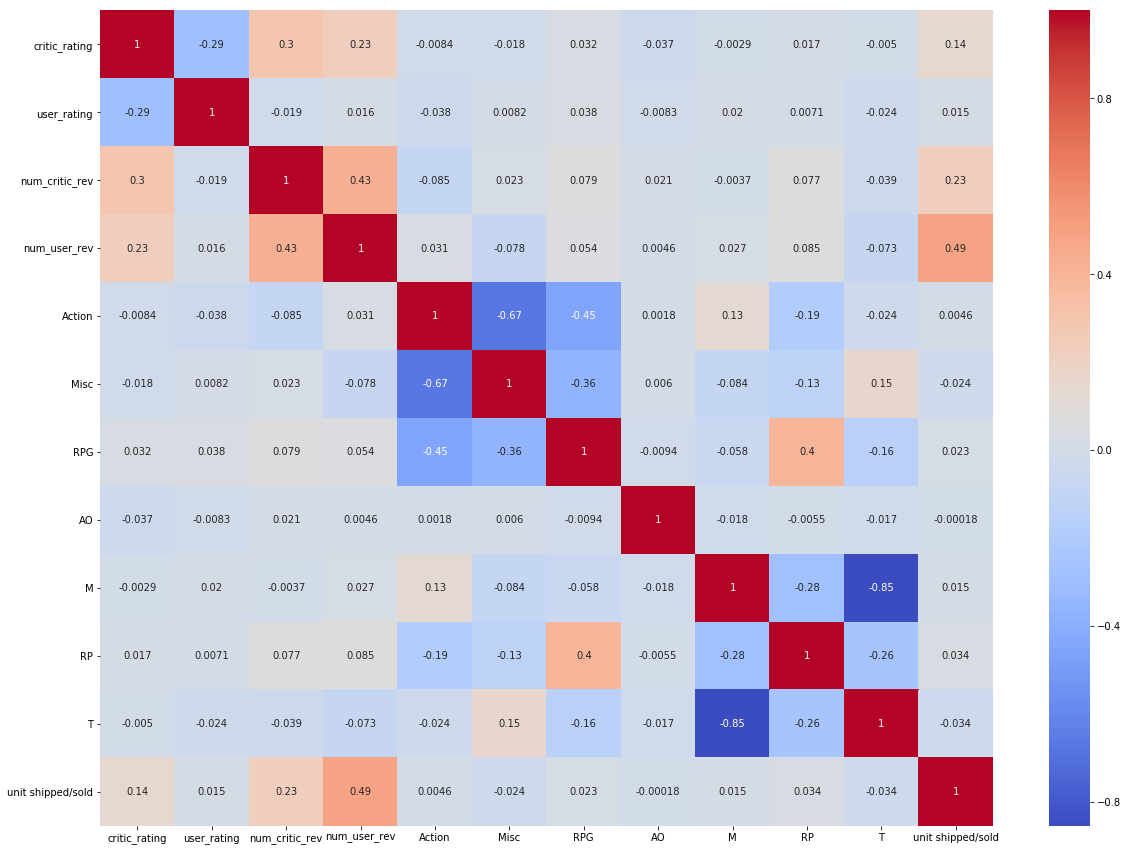

In [25]:
correlations = meta_vg.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(correlations,cmap='coolwarm',annot=True)

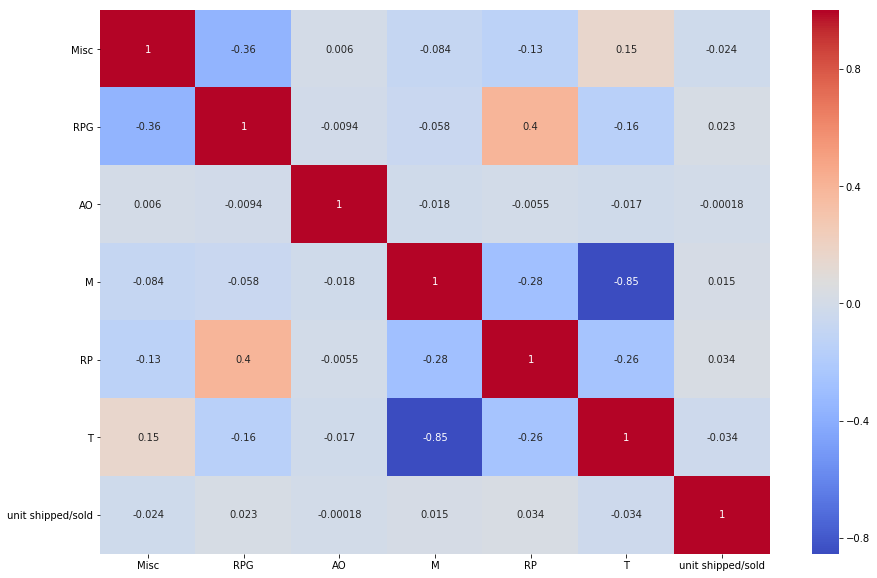

In [117]:
#Let's look at the relation between Mature rated games and Teen rated games real quick
ratings_df = meta_vg.iloc[:,-8:-1]
rating_corr = ratings_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(rating_corr,cmap='coolwarm',annot=True)
plt.savefig('ratings_heatmap.png')

### Some things to note here:
There's fairly high negative correlation between games rated M and T, and also with Misc and Action genres.
Also interesting to note, that right off the bat the number of user reviews has a higher correlation that that of the critic reviews. This might be due to the fact that it's easier to be a joe schmoe adding a review, while there's less professional reviewers.

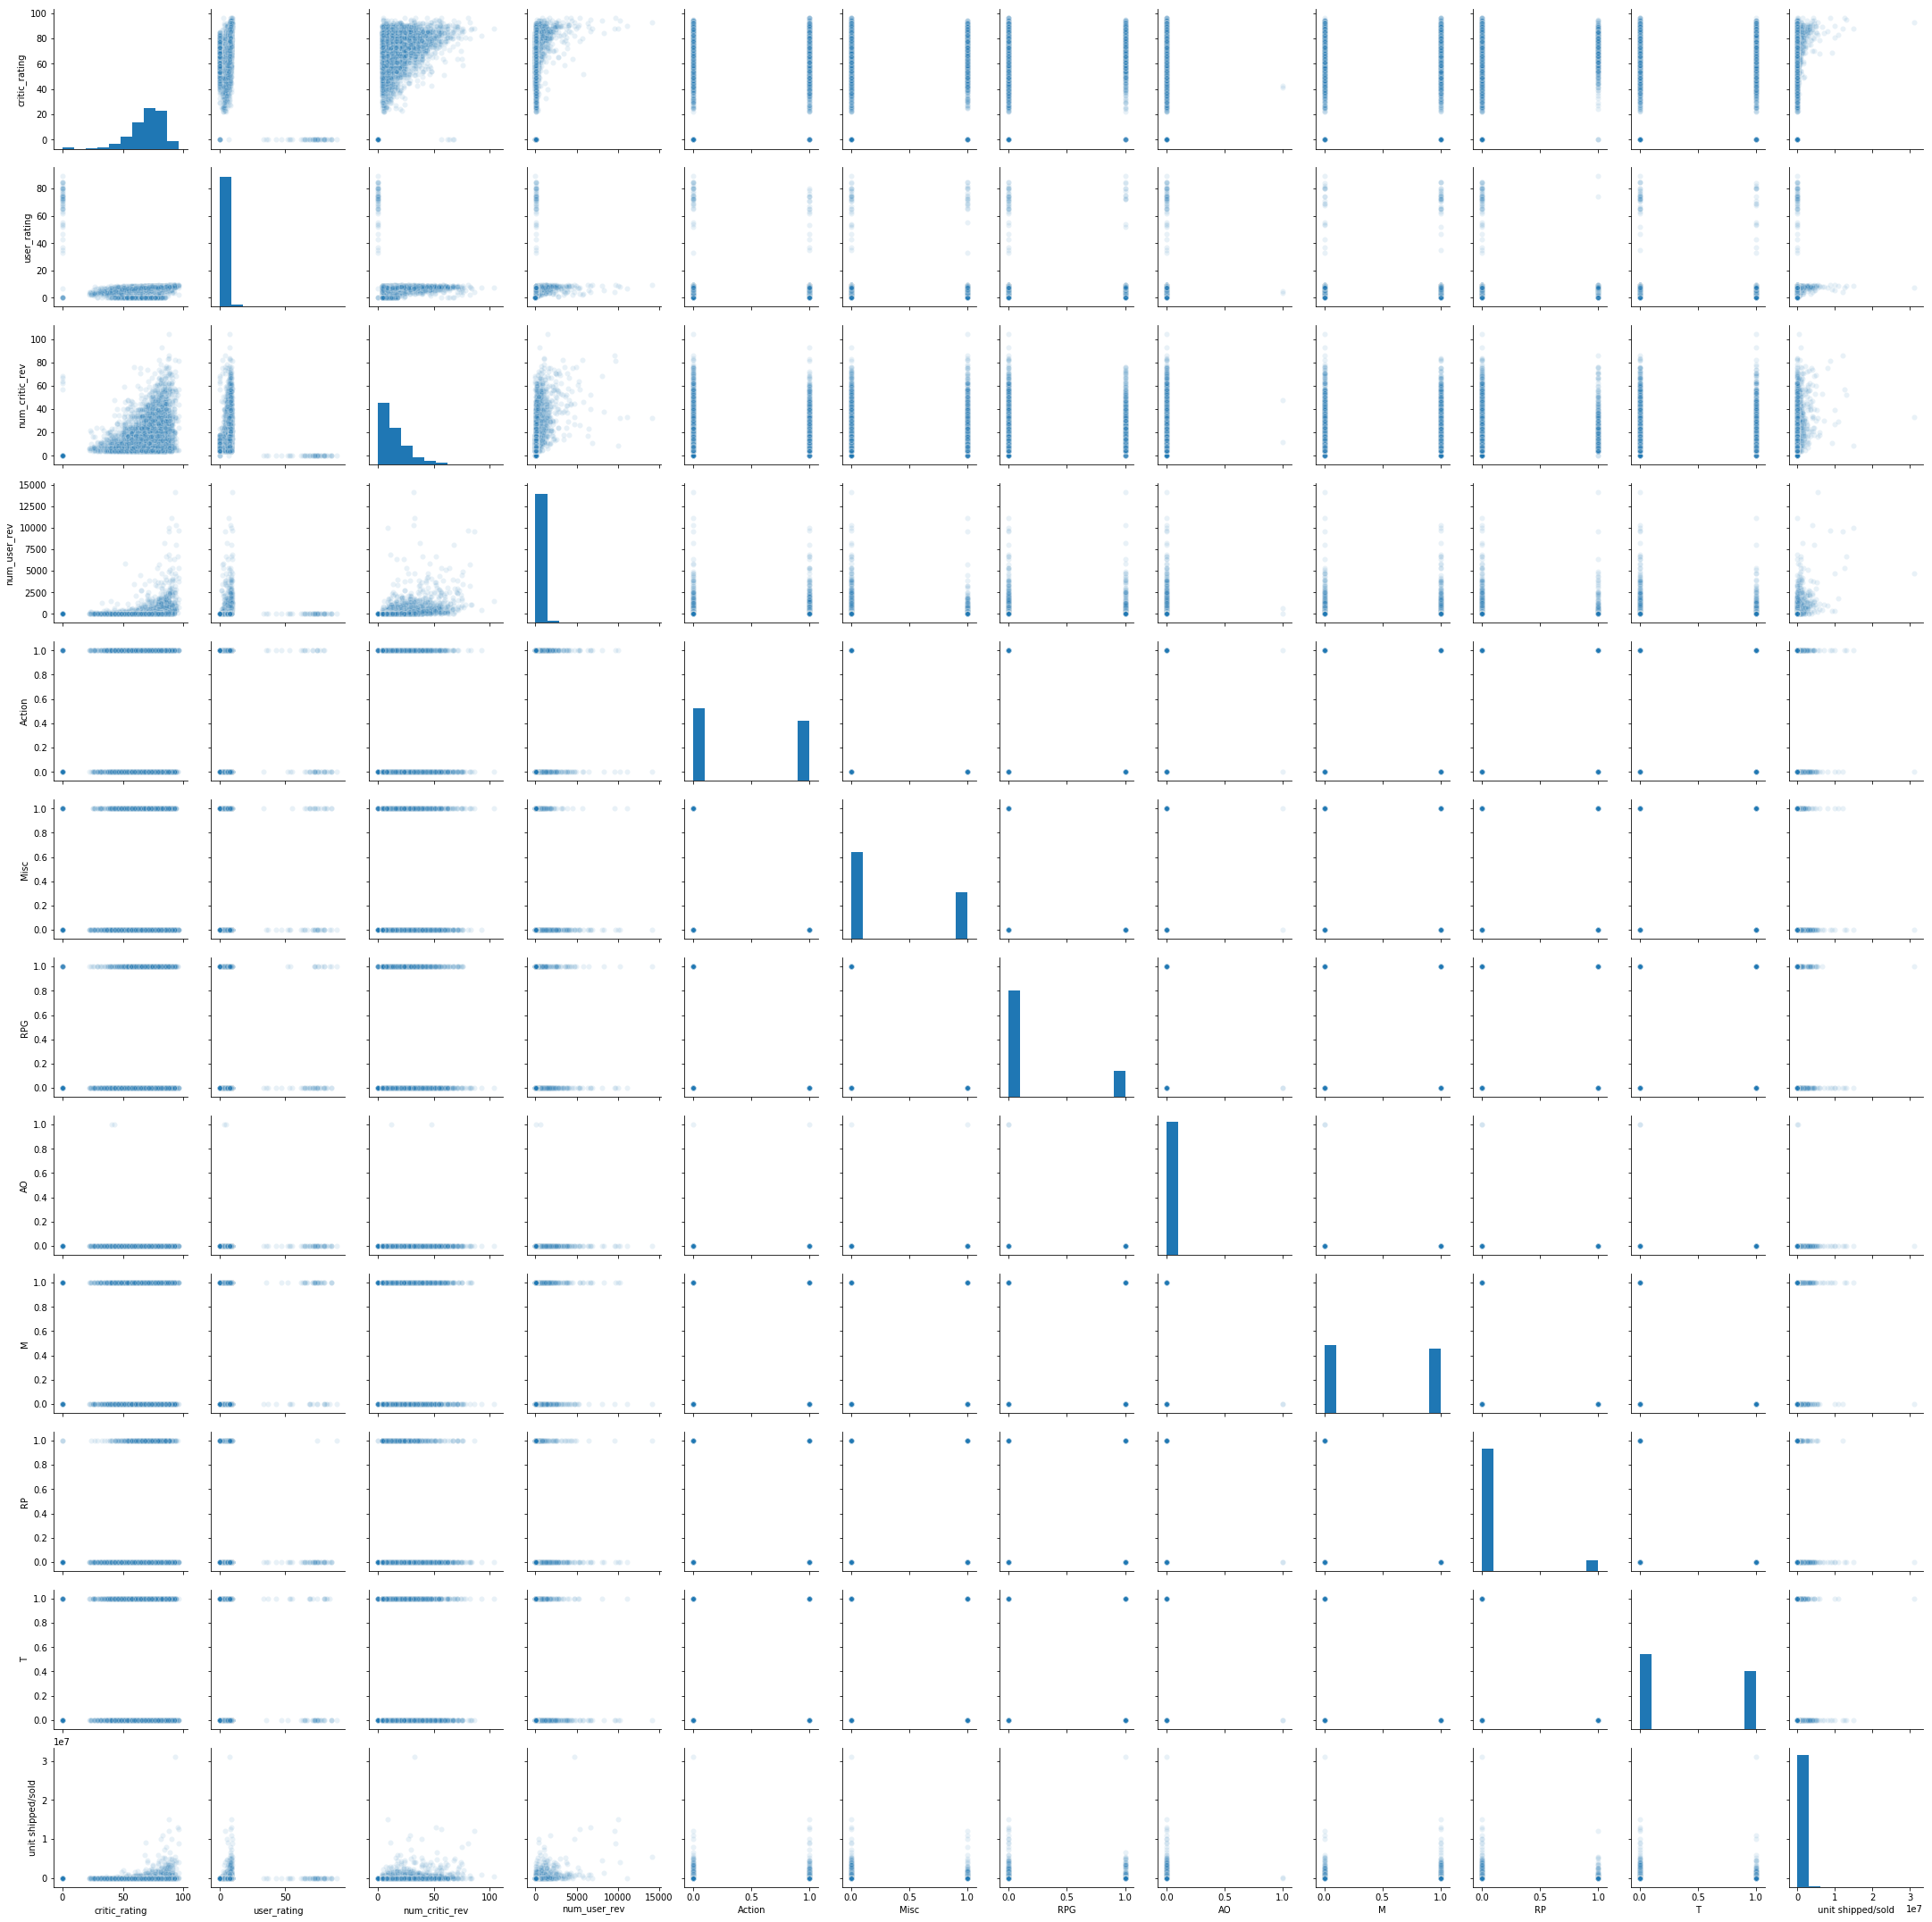

In [26]:
sns.pairplot(meta_vg,plot_kws=dict(alpha=.1))

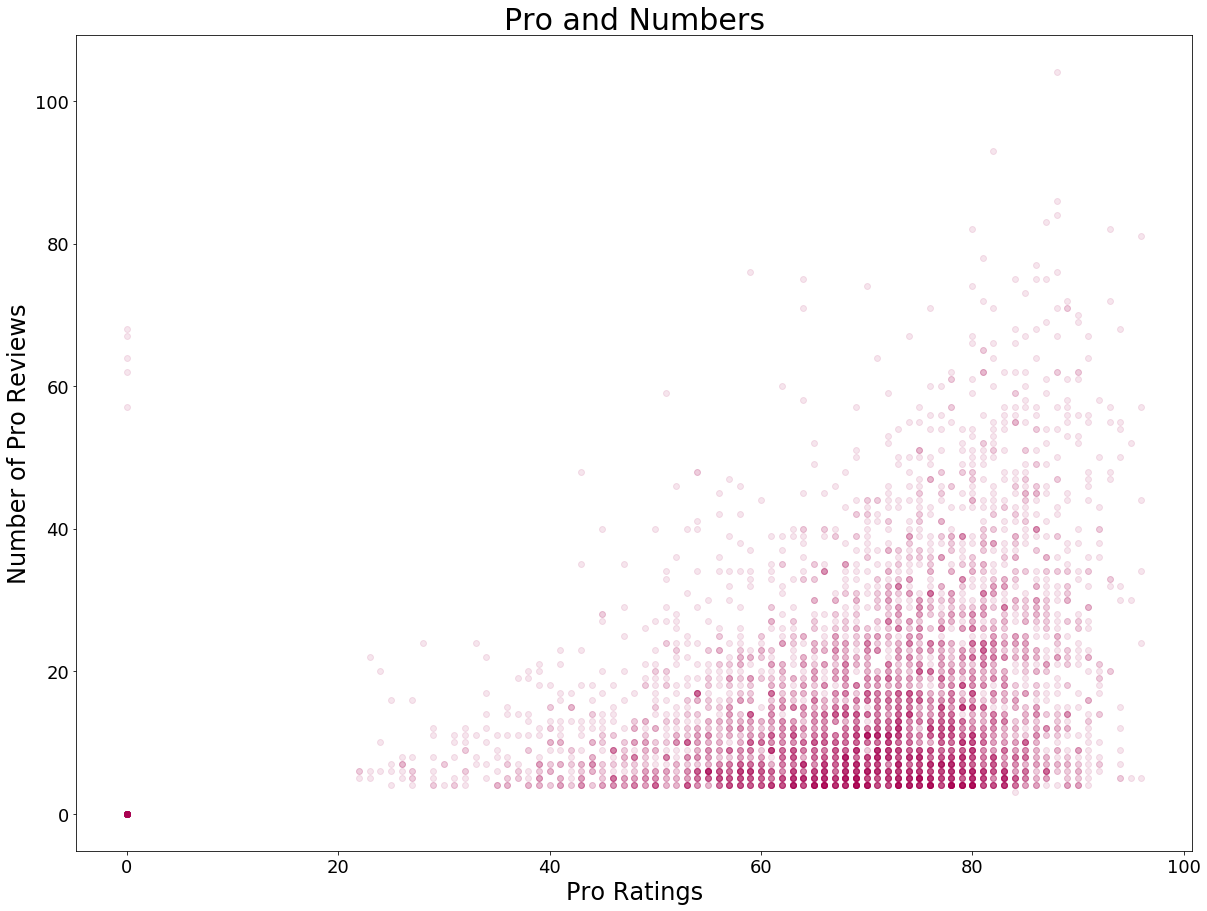

<Figure size 432x288 with 0 Axes>

In [152]:
plt.figure(figsize=[20,15])
plt.scatter(meta_vg['critic_rating'],meta_vg['num_critic_rev'],c='#AA0151', alpha = .1)
plt.xlabel("Pro Ratings",size= 24)
plt.ylabel("Number of Pro Reviews",size=24)
plt.title("Pro and Numbers", size=30)
plt.tick_params(labelsize=18)
plt.show()
plt.savefig('Critics and Numbers.jpeg',bbox_inches='tight')

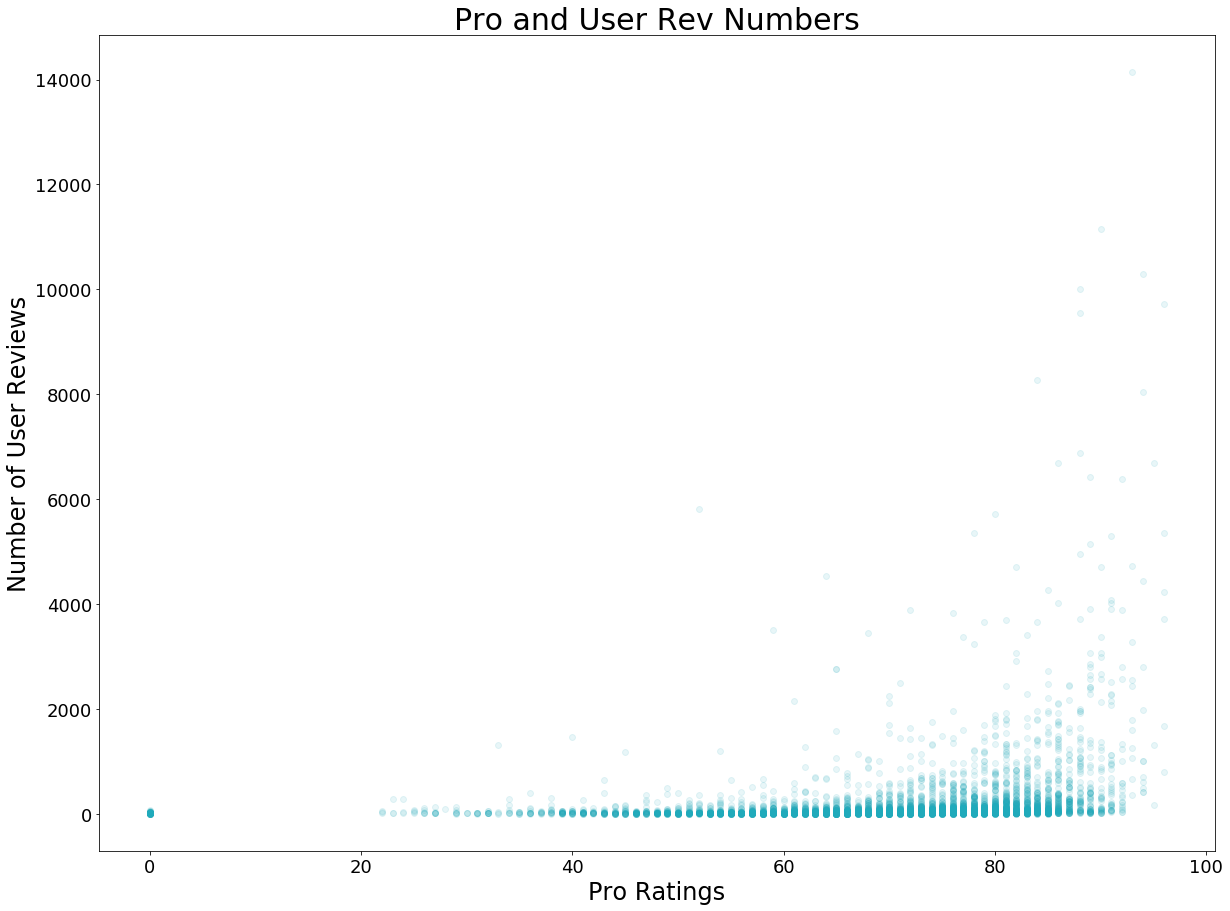

<Figure size 432x288 with 0 Axes>

In [154]:
plt.figure(figsize=[20,15])
plt.scatter(meta_vg['critic_rating'],meta_vg['num_user_rev'],c='#20AABB', alpha = .1)
plt.xlabel("Pro Ratings",size= 24)
plt.ylabel("Number of User Reviews",size=24)
plt.title("Pro and User Rev Numbers", size=30)
plt.tick_params(labelsize=18)
plt.show()
plt.savefig('Critics and Numbers1.jpeg',bbox_inches='tight')

### More notes
Possibly a quadratic correlation between the number of critic reviews and the rating a game gets. This may suggest that the more reviews a game gets by critics, there are similar likelihoods that it will be rated high.

Any way, time to look at some models and determine what to do with our features.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [28]:
old_mvg = meta_vg
new_mvg = meta_vg #Let's add a feature for this one to account for the relation between critic ratings and the number of reviews
new_mvg['cr2'] = new_mvg['critic_rating']**2

In [29]:
new_mvg = new_mvg[['title', 'critic_rating', 'cr2', 'user_rating', 'num_critic_rev',
       'num_user_rev', 'Action', 'Misc', 'RPG', 'AO', 'M', 'RP', 'T',
       'unit shipped/sold']]
new_mvg.head()

,title,critic_rating,cr2,user_rating,num_critic_rev,num_user_rev,Action,Misc,RPG,AO,M,RP,T,unit shipped/sold
0,.hack//G.U. Last Recode,69,4761,7.5,7,20,0,1,0,0,1,0,0,1000.0
1,007 Legends,26,676,2.7,5,101,1,0,0,0,0,0,1,1000.0
2,007: NightFire,59,3481,6.0,14,43,1,0,0,0,1,0,0,1000.0
3,007: Quantum of Solace,70,4900,6.1,18,59,1,0,0,0,0,0,1,30000.0
4,0RBITALIS,73,5329,7.3,9,4,1,0,0,0,0,0,1,1000.0


In [30]:
# Splitting the data 60-20-20 train/val/test for both new and old
X_old = old_mvg.iloc[:,1:-2]
y_old = old_mvg['unit shipped/sold']
X_new = new_mvg.iloc[:,1:-1]
y_new = new_mvg.iloc[:,-1]

In [31]:
def split_validate_loop(X, y, test_size, iterations):
    '''
    With X trains and y targets, use linear regression to help determine feature coefficients.
    Will loop through iterations number of times. Prints out the mean of all outcomes.
    '''
    
    lr = LinearRegression()
    val_score_mean = []
    val_score2_mean = []
    coef_array = []
    index = 0
    for x in range(iterations):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, shuffle= True)
        lr.fit(X_train, y_train)
        val_score = lr.score(X_val,y_val)
        val_score_mean.append(val_score)
        val_score2_mean.append(1.0 - (1-val_score)*(X_val.shape[0]-1.)/(X_val.shape[0] - X_val.shape[1]-1.))

        coef_row = []
        for feature, coef in zip(X.columns, lr.coef_):
            coef_row.append(lr.coef_)
        coef_array.append(coef_row)
    print('\nValidation R^2 mean score was: ', np.mean(val_score_mean))
    print('\nValidation R^2 std: ', np.std(val_score_mean))
    print('\nValidation Adj R^2 mean score was: ', np.mean(val_score2_mean))
    print('\nValidation Adj R^2std: ', np.std(val_score2_mean))
    mean_coef_array = np.mean(coef_array,axis = 0)
    print('Feature coefficient mean results: \n')
    for feature, coef in zip(X.columns, mean_coef_array[0]):
        print(feature, ':', f'{coef:.2f}')


In [32]:
split_validate_loop(X_old,y_old,.2,100)


Validation R^2 mean score was:  0.1740542424127975

Validation R^2 std:  0.17006233454824554

Validation Adj R^2 mean score was:  0.16584701266260854

Validation Adj R^2std:  0.1717522041779029
Feature coefficient mean results: 

critic_rating : 2001.35
user_rating : 2124.63
num_critic_rev : 661.32
num_user_rev : 585.29
Action : -9082.44
Misc : 13891.38
RPG : -4808.95
AO : -27956.72
M : 16079.57
RP : -2318.21
T : 14195.36


In [33]:
split_validate_loop(X_new,y_new,.2,100)


Validation R^2 mean score was:  0.22738865640387687

Validation R^2 std:  0.13759667539735768

Validation Adj R^2 mean score was:  0.21900589318221908

Validation Adj R^2std:  0.13908958688448997
Feature coefficient mean results: 

critic_rating : -6240.28
cr2 : 68.98
user_rating : -1065.72
num_critic_rev : 545.20
num_user_rev : 576.65
Action : -9438.27
Misc : 13074.49
RPG : -3636.22
AO : -31691.67
M : 18378.96
RP : -3219.24
T : 16531.96


### From these results...
I have run the above two cells multiple times and never get a definite answer on many things. The coefficient values from both new and old tend to flip flop. Sometimes the R^2/adj are better in new, sometimes better in old, the same goes for their variance. Both the critic and user ratings have opposite coefficients between the old and new models. However, they for the most part agree on coefficients for the genres. The R^2 for both of these is still low, I would still like to engineer the features.(Maybe I need to normalize things?)

In any case, I'm now curious about taking a smaller set of features. Since both the old and new models disagree in general on the ratings being a component, let's drop those?

In [34]:
no_rating = meta_vg.drop(['critic_rating','user_rating','cr2'], axis=1)
no_rating.head()

,title,num_critic_rev,num_user_rev,Action,Misc,RPG,AO,M,RP,T,unit shipped/sold
0,.hack//G.U. Last Recode,7,20,0,1,0,0,1,0,0,1000.0
1,007 Legends,5,101,1,0,0,0,0,0,1,1000.0
2,007: NightFire,14,43,1,0,0,0,1,0,0,1000.0
3,007: Quantum of Solace,18,59,1,0,0,0,0,0,1,30000.0
4,0RBITALIS,9,4,1,0,0,0,0,0,1,1000.0


In [35]:
X_norat = no_rating.iloc[:,1:-1]
y_norat = no_rating.iloc[:,-1]
split_validate_loop(X_norat,y_norat,.2,100)


Validation R^2 mean score was:  0.20943436374341676

Validation R^2 std:  0.1521807139042176

Validation Adj R^2 mean score was:  0.20301859212366088

Validation Adj R^2std:  0.15341572420641594
Feature coefficient mean results: 

num_critic_rev : 1223.44
num_user_rev : 587.04
Action : -11093.26
Misc : 11788.62
RPG : -695.36
AO : -82549.24
M : 35492.69
RP : 11238.83
T : 35817.73


### Hmmm...
No meaningful improvements. Perhaps these are the best I can get? Let's just go back to the old dataset and run LASSO on it. For comparison sake, I'll see what Ridge might score against it, but my intuition is that we have plenty of features that may just be noise.

But let's do a last hurrah with OLS specifically. I'm going to set my filter for important features with P>|t| at most .05.

In [36]:
X_old_train, X_old_test, y_old_train, y_old_test = train_test_split(X_old, y_old, test_size = .2) # leave a chunk for testing later
Xo_train, Xo_val, yo_train, yo_val = train_test_split(X_old_train,y_old_train, test_size = .2)

In [40]:
model = sm.OLS(yo_train, sm.add_constant(Xo_train))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      unit shipped/sold   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     124.4
Date:                Thu, 18 Jul 2019   Prob (F-statistic):          4.56e-204
Time:                        19:08:27   Log-Likelihood:                -53414.
No. Observations:                3580   AIC:                         1.068e+05
Df Residuals:                    3570   BIC:                         1.069e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.236e+05   9.11e+04     -1.356      0.175   -3.02e+05    5.51e+04
critic_rating   2412.3722    954.006      2.529      0.011     541.921    4282.823
user_rating     2465.5515   2114.967      1.166      0.244   -1681.114    6612.217
num_critic_rev  1261.0721   1057.571      1.192      0.233    -812.432    3334.576
num_user_rev     588.7503     20.503     28.715      0.000     548.551     628.949
Action         -4.837e+04   3.44e+04     -1.406      0.160   -1.16e+05    1.91e+04
Misc           -3.294e+04   3.53e+04     -0.934      0.350   -1.02e+05    3.62e+04
RPG            -4.227e+04   3.86e+04     -1.096      0.273   -1.18e+05    3.34e+04
AO             -6.416e+04   4.09e+05     -0.157      0.875   -8.66e+05    7.38e+05
M              -9963.5819   1.12e+05     -0.089      0.929   -2.29e+05    2.09e+05
RP             -2.596e+04   1.17e+05     -0.222      0.824   -2.55e+05    2.03e+05
T              -2.349e+04   1.12e+05     -0.210      0.834   -2.43e+05    1.96e+05
==============================================================================
Omnibus:                     7780.512   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         65170309.695
Skew:                          18.993   Prob(JB):                         0.00
Kurtosis:                     662.889   Cond. No.                     9.74e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.82e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Holy poop
This model is bad. Kurtosis of 600. Cond. No. is through the roof. Multicollinearity, here we come!
The only relevant looking features are **critic ratings** and the **number of user reviews**. Let's see if LASSO and Ridge think so as well.

Since we're going to use LASSO, we'll need to normalize our values.

In [41]:
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [42]:
std = StandardScaler()
std.fit(Xo_train.values) #Fit values
Xstd_train = std.transform(Xo_train.values) # Apply scaler

In [43]:
lasso_model = Lasso(alpha = 10000)
lasso_model.fit(Xstd_train, yo_train)

Lasso(alpha=10000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [44]:
list(zip(Xo_train.columns, lasso_model.coef_))

[('critic_rating', 23288.406082150846),
 ('user_rating', 2540.8215899090173),
 ('num_critic_rev', 12494.449712344054),
 ('num_user_rev', 386515.02831427485),
 ('Action', -0.0),
 ('Misc', 0.0),
 ('RPG', 0.0),
 ('AO', -0.0),
 ('M', 0.0),
 ('RP', -0.0),
 ('T', -0.0)]

### A little different than what I expected:
I Still got that **critic rating** and the **number of user reviews** as relevant features. However, it picked up **user rating** as an important feature. I am also surprised that it *dropped* **Mature** rated titles. Let's look at our hyperparameter of alpha and see if we can find a better value for it.

In [45]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [46]:
def alphapiper(X_train, X_val, y_train, y_val):
    '''
    Create a pipeline and use it to find the best alpha value.
    '''
    alphalist = 10**(np.linspace(-2,2,200))
    err_vec_val = np.zeros(len(alphalist))
    err_vec_train = np.zeros(len(alphalist))
    X_train = pd.DataFrame(X_train) ## Just in case the passed in values are regular arrays instead of DFs
    X_val = pd.DataFrame(X_val)
    for i,curr_alpha in enumerate(alphalist):

        steps = [('standardize', StandardScaler()), 
                 ('lasso', Lasso(alpha = curr_alpha))]

        pipe = Pipeline(steps)
        pipe.fit(X_train.loc[:,:].values, y_train)

        val_set_pred = pipe.predict(X_val.loc[:,:].values)
        err_vec_val[i] = mae(y_val, val_set_pred)

    plt.plot(np.log10(alphalist),err_vec_val)
    print(np.min(err_vec_val))

C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Animaznman\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You 

171094.6113917343


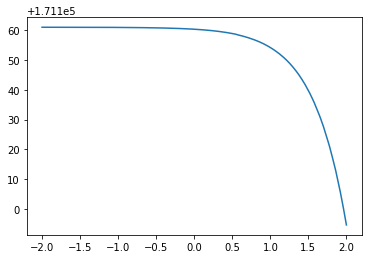

In [47]:
Xstd_val = std.transform(Xo_val.values)
alphapiper(Xstd_train,Xstd_val,yo_train,yo_val)

In [48]:
#Let's see what we get with this new alpha
lasso_model = Lasso(alpha = 171094.6113917343)
lasso_model.fit(Xstd_val, yo_val)

Lasso(alpha=171094.6113917343, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
list(zip(Xo_train.columns, lasso_model.coef_))

[('critic_rating', 0.0),
 ('user_rating', 0.0),
 ('num_critic_rev', 0.0),
 ('num_user_rev', 142218.82601467788),
 ('Action', 0.0),
 ('Misc', 0.0),
 ('RPG', -0.0),
 ('AO', -0.0),
 ('M', -0.0),
 ('RP', -0.0),
 ('T', 0.0)]

### What?
So, I saw that for some reason the pipeline doesn't have a local minimum. That's rather concerning. And now we see that with this alpha value, the only feature that matters is the **number of user reviews**. 

In most of the cases so far, I've run into the idea that somehow the ratings and reviews are important (just a few times where the genre mattered.) I want to run another pass on my **quadratic critic rating** once more and keep those as my features. Let's see how it performs. Also, I just realized that the user rating is on a scale of 1-10, whereas the critic rating is of 1-100. Let's scale up the user score by 10 while we're at this.

In [50]:
Xo_train['cr2'] = Xo_train['critic_rating']**2
Xo_val['cr2'] = Xo_val['critic_rating']**2

Xo_train = Xo_train[['critic_rating', 'cr2', 'user_rating', 'num_critic_rev', 'num_user_rev',
       'Action', 'Misc', 'RPG', 'AO', 'M', 'RP', 'T']]
Xo_val = Xo_val[['critic_rating', 'cr2', 'user_rating', 'num_critic_rev', 'num_user_rev',
       'Action', 'Misc', 'RPG', 'AO', 'M', 'RP', 'T']]
Xo_train.drop(Xo_train.columns[5:], axis =1,inplace = True)
Xo_val.drop(Xo_val.columns[5:], axis =1,inplace = True)

C:\Users\Animaznman\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Animaznman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [51]:
Xo_train['user_rating'] = Xo_train['user_rating']*10
Xo_val['user_rating'] = Xo_val['user_rating']*10
Xo_train.head()

,critic_rating,cr2,user_rating,num_critic_rev,num_user_rev
5134,79,6241,81.0,4,54
564,68,4624,71.0,48,249
1655,71,5041,77.0,4,9
3084,72,5184,73.0,15,11
4825,73,5329,59.0,24,141


In [52]:
Xo_val.head()

,critic_rating,cr2,user_rating,num_critic_rev,num_user_rev
2278,74,5476,60.0,7,266
4300,83,6889,71.0,4,16
711,25,625,32.0,7,20
1334,68,4624,68.0,14,19
3646,50,2500,75.0,18,20


In [53]:
std.fit(Xo_train.values) #Fit values
Xstd_train = std.transform(Xo_train.values)
Xstd_val = std.transform(Xo_val.values)

model = sm.OLS(yo_train, sm.add_constant(Xstd_train))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      unit shipped/sold   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     225.5
Date:                Thu, 18 Jul 2019   Prob (F-statistic):          1.06e-209
Time:                        19:13:16   Log-Likelihood:                -53412.
No. Observations:                3580   AIC:                         1.068e+05
Df Residuals:                    3574   BIC:                         1.069e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.362e+05   1.22e+04     11.154      0.000    1.12e+05     1.6e+05
x1         -1.375e+05   7.39e+04     -1.862      0.063   -2.82e+05    7249.930
x2           1.71e+05   7.25e+04      2.359      0.018    2.89e+04    3.13e+05
x3         -1.378e+04   1.76e+04     -0.783      0.434   -4.83e+04    2.07e+04
x4          1.584e+04   1.38e+04      1.147      0.251   -1.12e+04    4.29e+04
x5          3.857e+05   1.38e+04     27.924      0.000    3.59e+05    4.13e+05
==============================================================================
Omnibus:                     7777.833   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         64919182.942
Skew:                          18.979   Prob(JB):                         0.00
Kurtosis:                     661.613   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### I give up
I don't know if any more amount of feature engineering would be able to increase the R^2/adjusted value. Or for that matter if I could produce consistent results across features. I'll just move on to cross validation of the model. And I should make sure to cross validate specifically because I have a low number of observations.

In [54]:
X = X_old
y = y_old
X['cr2'] = X_old['critic_rating'] **2
X = X_old[['critic_rating', 'cr2', 'user_rating', 'num_critic_rev', 'num_user_rev',
       'Action', 'Misc', 'RPG', 'AO', 'M', 'RP', 'T']]
X.drop(Xo_train.columns[5:], axis =1,inplace = True)
std = StandardScaler()
std.fit(X.values)
Xstd = std.transform(X.values)
X_train, X_test, y_train, y_test = train_test_split(Xstd,y,test_size=.2)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

kf = KFold(n_splits = 5, shuffle=True)
print(np.mean(cross_val_score(lm, X_train, y_train, cv=kf, scoring='r2')))

0.22461092861065862


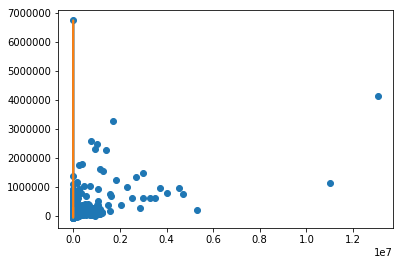

In [83]:
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)
plt.plot(X_test,predictions)

# This model sucks

### Let's see
How bad my predictions are based off of this model

In [56]:
print("The average difference between the expected sales and actual sales is: +-"+str(np.mean(abs(y_test-predictions))))
print("The standard deviation of this is: "+str(np.std(abs(y_test-predictions))))

The average difference between the expected sales and actual sales is: +-173320.96538709127
The standard deviation of this is: 573003.2533508114


### Maybe...
I should look at a different model? Linear Regression clearly is doing poop at this. Perhaps Polynomial Regression?

In [59]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Perceptron
clf = Perceptron(fit_intercept=False, max_iter=10, tol=None, shuffle=False)

In [100]:
def polypipe(X, y, degree):
    '''
    Loop through the highest degree to the lowest degree, then find which one has the best performance.
    '''
    performances = []
    stds = []
    for deg in range(degree):
        pnf = PolynomialFeatures(degree = deg)
        X_poly = pnf.fit_transform(X)
        lm = LinearRegression()
        lm.fit(X_poly,y)
        y_poly_pred = lm.predict(X_poly)
        print(np.mean(abs(y-y_poly_pred)))
        performances.append(np.mean(abs(y-y_poly_pred)))
        print(np.std(abs(y-y_poly_pred)))
        stds.append(np.std(abs(y-y_poly_pred)))
#         plt.scatter(X,y)
        plt.plot(X,y_poly_pred)
        plt.show()
    minperf = min(performances)
    minperfpos = performances.index(minperf)
#     minstd = stds[minperfpos]
    
    print("The polynomial of degree"+str(minperfpos)+" has the best performance with an average difference of"+str(minperf)+".")
#     print("The standard deviation of this polynomial is "+minstd+".")

212806.83034860517
761839.1385702883


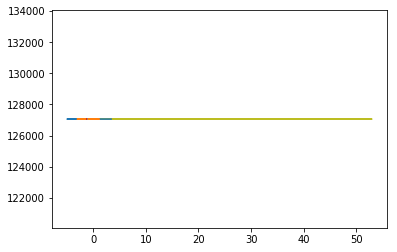

170377.41258012757
664793.7427267072


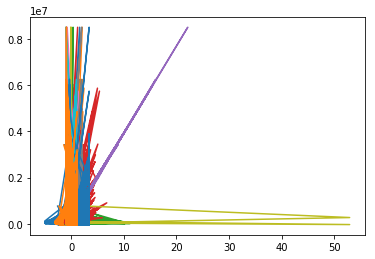

184192.92615921787
634562.5279618566


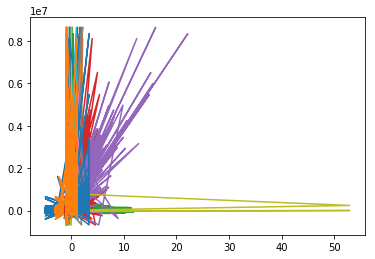

185223.1400618076
455749.5297927311


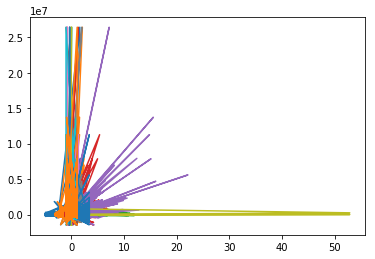

147521.30401198418
351839.02784458804


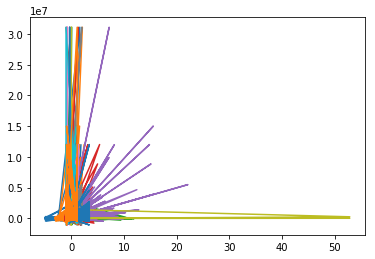

121064.20033877922
276634.8646852984


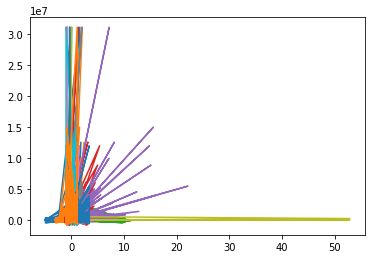

85808.78372929135
223993.42837402786


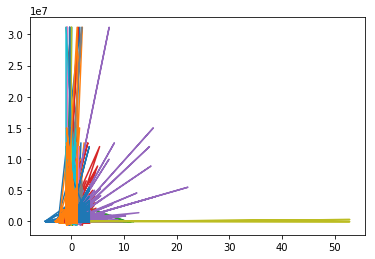

77190.72838102923
181979.52196493172


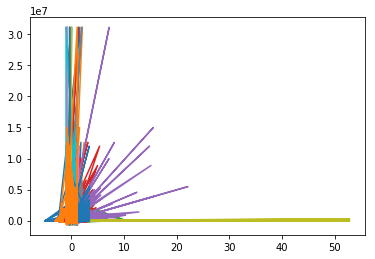

73712.40030359248
173186.3132440435


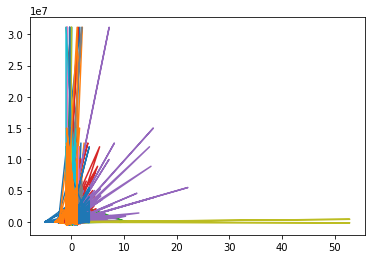

80516.73164843126
213797.9717918293


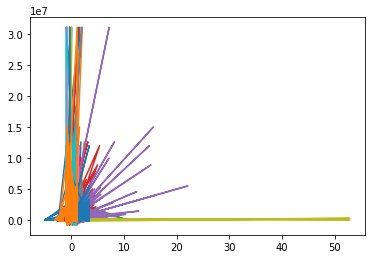

The polynomial of degree8 has the best performance with an average difference of73712.40030359248.


In [102]:
polypipe(X_train,y_train,10)

118519.9332466414
291960.031493388


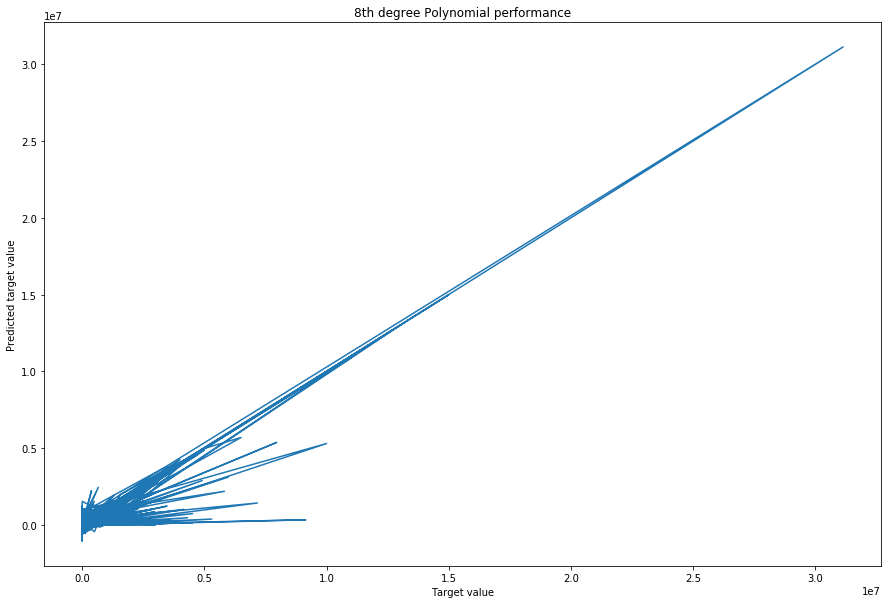

In [128]:
# Let me just recreate that scenario and remake the std.
pnf = PolynomialFeatures(degree = 8)
X_poly = pnf.fit_transform(X)
lm = LinearRegression()
lm.fit(X_poly,y)
y_poly_pred = lm.predict(X_poly)
print(np.mean(abs(y-y_poly_pred)))
print(np.std(abs(y-y_poly_pred)))
plt.figure(figsize=[15,10])
plt.title("8th degree Polynomial performance")
plt.xlabel("Target value")
plt.ylabel("Predicted target value")
plt.plot(y,y_poly_pred)
plt.show()

### This means...
An 8th degree polynomial creates the lowest amount of distance between the prediction and the actual test set. But what does this mean for the actual question?

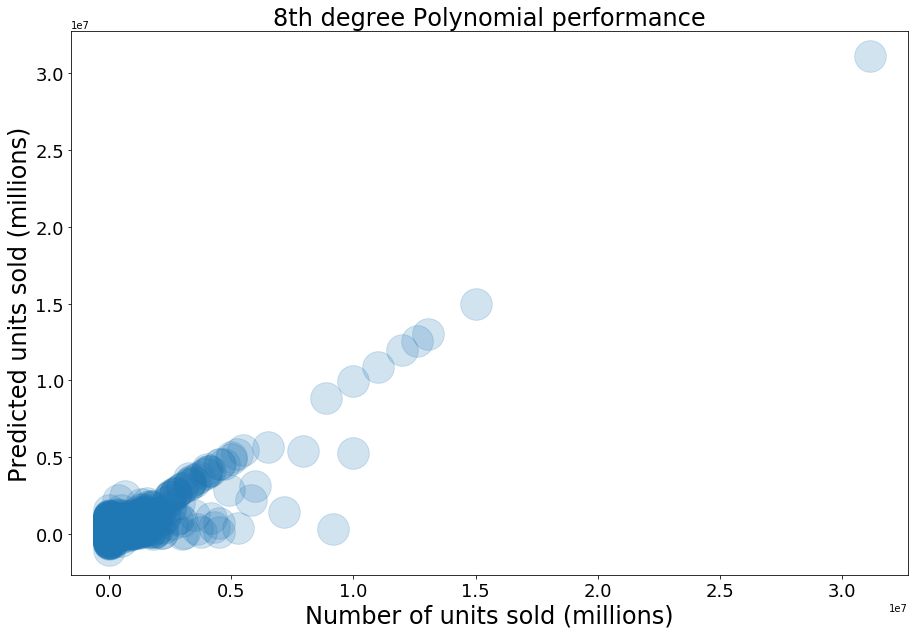

<Figure size 432x288 with 0 Axes>

In [149]:
plt.figure(figsize=[15,10])
plt.title("8th degree Polynomial performance", size=24)
plt.xlabel("Number of units sold (millions)", size=24)
plt.ylabel("Predicted units sold (millions)", size=24)
plt.scatter(y,y_poly_pred,s=1000,alpha=.2)
plt.tick_params(labelsize=18)
plt.show()
plt.savefig('8th degree performance.png')